In [99]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import gco
import maxflow
import skimage
from sklearn.ensemble import RandomForestClassifier

device = "mps"

In [3]:
def initial_labels(image, d, n_segments, method="slic"):
    if method == "slic":
        seg = skimage.segmentation.slic(image, compactness=1, max_num_iter=10,
                                        n_segments=n_segments, start_label=0,
                                        enforce_connectivity=False, convert2lab=True)
        
        # while len(np.unique(seg)) > n_segments, merge smallest segments
        while len(np.unique(seg)) > n_segments:
            # count number of pixels in each segment
            segments, counts = np.unique(seg, return_counts=True)
            # find smallest segment
            smallest1 = segments[np.argmin(counts)]
            # find second smallest segment
            counts[smallest1] = np.max(counts)
            smallest2 = segments[np.argmin(counts)]
            # merge smallest segments
            seg[seg == smallest1] = smallest2

        t = torch.tensor(seg).unsqueeze(0).unsqueeze(0).float()
        labels = torch.nn.functional.interpolate(t, (d, d), mode="nearest")
        labels = labels.squeeze().to(torch.int64).reshape(d * d)
        labels = torch.nn.functional.one_hot(labels, n_segments).float()
        return labels
    elif method == "random":
        labels = torch.randint(n_segments, (d * d,))
        labels = torch.nn.functional.one_hot(labels, n_segments).float()
        return labels

def graph_cut(probabilities, d, k, lambda_):
    lambda_ = lambda_
    # avoid division by zero
    probabilities[probabilities == 0] = 1e-10
    unary = -1 * np.log(probabilities.reshape(d, d, k))
    pairwise = (1 - np.eye(k)) * lambda_
    # result = gco.cut_grid_graph_simple(unary, pairwise)
    result = maxflow.aexpansion_grid(unary.astype(np.double), pairwise.astype(np.double))
    result = result.reshape(d * d)
    return result

def epoch_schedule(x_, max_epochs=40, min_epochs=10, n_iter=4):
    return_int = False
    if not isinstance(x_, np.ndarray):
        x = np.array([x_])
        return_int = True
    else:
        x = x_
    x[x == 0] = 1
    v = ((5*n_iter)/x) + min_epochs
    too_high = v > max_epochs
    v[too_high] = max_epochs
    # convert to int
    v = v.astype(int)
    if return_int:
        return v[0]
    else:
        return v
    
def side_by_side(images, titles=None, height=3):
    fig, axes = plt.subplots(1, len(images), figsize=(height*len(images), height))
    for i, image in enumerate(images):
        axes[i].imshow(image)
        axes[i].axis("off")
        if titles is not None:
            axes[i].set_title(titles[i])
    plt.show()

In [143]:
# class GNEMNet_FCN(torch.nn.Module):
    # def __init__(self, image_size=(512,512), tile_size=(32,32), k=25, n_filters=16, dropout=0.2, subset_size=0.5):
    #     super(GNEMNet_FCN, self).__init__()
    #     self.conv1 = torch.nn.Conv2d(3, n_filters, 3, padding=1, stride=1)
    #     self.BN1 = torch.nn.BatchNorm2d(n_filters)
    #     self.dropout1 = torch.nn.Dropout(dropout)
    #     self.conv2 = torch.nn.Conv2d(n_filters, 1, 3, padding=1, stride=1)
    #     self.BN2 = torch.nn.BatchNorm2d(1)
    #     self.dropout2 = torch.nn.Dropout(dropout)
    #     self.output = torch.nn.Conv2d(1, k, 1, padding=0, stride=1)
    #     self.training_mode = True
    #     self.tile_size = tile_size
    #     self.subset_size = subset_size
    #     num_patches_total = (image_size[0] // tile_size[0]) * (image_size[1] // tile_size[1])
    #     self.training_patch_indices = torch.arange(0, round(num_patches_total * subset_size), dtype=torch.int)
    #     self.training_patch_indices_have_changed = True
    #     self.patches_to_train_on = None
    #     self.predict_all_patches = False

    # def set_predict_all_patches(self, predict_all_patches):
    #     self.predict_all_patches = predict_all_patches
    #     self.training_patch_indices_have_changed = True

    # def enter_training_mode(self):
    #     self.training_mode = True
    
    # def enter_inference_mode(self):
    #     self.training_mode = False

    # def set_training_patch_indices(self, indices):
    #     self.training_patch_indices = torch.tensor(indices, dtype=torch.int)
    #     self.training_patch_indices_have_changed = True

    # def forward(self, x):
    #     # Divide image into patches and return intended indices as patches
    #     if self.training_mode:
    #         if self.training_patch_indices_have_changed:
    #             patches = torch.nn.functional.unfold(x, kernel_size=self.tile_size, stride=self.tile_size, dilation=1, padding=0)
    #             patches = patches.view(3, self.tile_size[0], self.tile_size[1], -1).permute(3, 0, 1, 2)
    #             if not self.predict_all_patches:
    #                 self.patches_to_train_on = patches[self.training_patch_indices]
    #             else:
    #                 self.patches_to_train_on = patches
    #             self.training_patch_indices_have_changed = False

    #         x = self.patches_to_train_on

    #     # training shape: (num_patches * subset_size, k, tile_width, tile_height)
    #     # inference shape: (1, k, image_width, image_height)

    #     x = self.conv1(x)
    #     x = self.BN1(x)
    #     x = torch.relu(x)
    #     x = self.dropout1(x)

    #     x = self.conv2(x)
    #     x = self.BN2(x)
    #     x = torch.relu(x)
    #     x = self.dropout2(x) # [num_patches * subset_size, 1, tile_width, tile_height]

    #     x = self.output(x)

    #     if self.training_mode:
    #         # [num_patches * subset_size, k, tile_width, tile_height]
    #         x = torch.nn.functional.avg_pool2d(x, self.tile_size, stride=self.tile_size, padding=0)
    #         # [num_patches * subset_size, k, 1, 1]

    #     x = torch.softmax(x, dim=1)
    #     return x
    
class GNEMNet_FCN_2(torch.nn.Module):
    def __init__(self, image_size=(512,512), tile_size=(32,32), k=25, n_filters=16, dropout=0.2, subset_size=0.5):
        super(GNEMNet_FCN_2, self).__init__()
        self.tile_size = np.array(tile_size)
        self.conv1 = torch.nn.Conv2d(3, n_filters, 3, padding=0, stride=1)
        self.BN1 = torch.nn.BatchNorm2d(n_filters)
        self.dropout1 = torch.nn.Dropout(dropout)
        self.conv2 = torch.nn.Conv2d(n_filters, 1, 3, padding=0, stride=1)
        self.BN2 = torch.nn.BatchNorm2d(1)
        self.dropout2 = torch.nn.Dropout(dropout)
        self.conv3 = torch.nn.Conv2d(1, k, self.tile_size, stride=1)
    
        self.training_mode = True
        self.tile_size = tile_size
        self.d = image_size[0] // tile_size[0]
        self.subset_size = subset_size
        num_patches_total = (image_size[0] // tile_size[0]) * (image_size[1] // tile_size[1])
        self.training_patch_indices = torch.arange(0, round(num_patches_total * subset_size), dtype=torch.int)
        self.training_patch_indices_have_changed = True
        self.patches_to_train_on = None
        self.predict_all_patches = False

    def set_predict_all_patches(self, predict_all_patches):
        self.predict_all_patches = predict_all_patches
        self.training_patch_indices_have_changed = True

    def enter_training_mode(self):
        self.train()
        self.training_mode = True
    
    def enter_inference_mode(self):
        self.eval()
        self.training_mode = False

    def set_training_patch_indices(self, indices):
        self.training_patch_indices = indices.clone().detach()
        self.training_patch_indices_have_changed = True

    def grid_pad(self, image_tensor):
        padding = 2
        tile_size = self.tile_size
        size_with_padding = (tile_size[0] + 2 * padding, tile_size[1] + 2 * padding)
        image_tensor = torch.nn.functional.pad(image_tensor, (padding, padding, padding, padding), mode='reflect')
        patches = torch.nn.functional.unfold(image_tensor, kernel_size=size_with_padding, stride=tile_size, dilation=1, padding=0)
        patches = patches.view(3, size_with_padding[0], size_with_padding[1], -1).permute(3, 0, 1, 2)
        return patches

    def forward(self, x):
        # Divide image into patches and return intended indices as patches
        if self.training_mode:
            if x.dim() == 4 and x.shape[0] > 1: # inputs are already patches
                x = x
            else: # inputs have to be divided into patches
                if self.training_patch_indices_have_changed:
                    patches = self.grid_pad(x)
                    if not self.predict_all_patches:
                        self.patches_to_train_on = patches[self.training_patch_indices]
                    else:
                        self.patches_to_train_on = patches
                    self.training_patch_indices_have_changed = False

                x = self.patches_to_train_on
        else:
            if x.dim() < 4:
                x = x.unsqueeze(0)
            x = torch.nn.functional.pad(x, (17, 17, 17, 17), mode='reflect', value=0)

        if not self.training_mode:
            print(x.shape)

        # training shape: [num_patches * subset_size, 3, tile_width + 4, tile_height + 4]
        # inference shape: [1, 3, image_width + 4, image_height + 4]

        x = self.conv1(x)
        x = self.BN1(x)
        x = torch.relu(x)
        x = self.dropout1(x)

        if not self.training_mode:
            print(x.shape)

        # training shape: [num_patches * subset_size, n_filters, tile_width + 2, tile_height + 2]
        # inference shape: [1, n_filters, image_width + 2, image_height + 2]

        x = self.conv2(x)
        x = self.BN2(x)
        x = torch.relu(x)
        x = self.dropout2(x)

        # training shape: [num_patches * subset_size, 1, tile_width, tile_height]
        # inference shape: [1, 1, image_width, image_height]
        
        # if self.training_mode:
        #     self.conv3.stride = self.tile_size
        # else:
        #     self.conv3.stride = (1, 1)

        if not self.training_mode:
            print(x.shape)

        x = self.conv3(x)

        if not self.training_mode:
            print(x.shape)

        # training shape: [num_patches * subset_size, k, 1, 1]
        # inference shape: [1, k, 16, 16] OR [1, k, 481, 481]

        x = torch.softmax(x, dim=1)
        return x

In [144]:
class GNEMS_Segmentor:
    def __init__(self, d=16, n_filters=16, dropout=0.2,
                lambda_=0.3, size=(512, 512), lr=0.001,
                iterations=100, subset_size=0.5,
                prediction_stride=1, slic_segments=100,
                sigma=3, compactness=10, seed=0, k=10, epochs=10,
                initialization_method="slic", epoch_schedule=None,
                max_epochs=40, min_epochs=10):
        self.d = d
        self.n_filters = n_filters
        self.dropout = dropout
        self.lambda_ = lambda_
        self.size = size
        self.tile_size = (size[0] // d, size[1] // d)
        self.num_patches = (size[0] // self.tile_size[0]) * (size[1] // self.tile_size[1])
        self.lr = lr
        self.iterations = iterations
        self.subset_size = subset_size
        self.prediction_stride = prediction_stride
        self.seed = seed
        self.net = None
        self.losses = []
        self.intermediate_partitions = []
        self.intermediate_probabilities = []
        self.intermediate_graphs = []
        self.slic_segments = slic_segments
        self.sigma = sigma
        self.compactness = compactness
        self.k = k
        self.initial_labels = None
        self.epochs = epochs
        self.initialization_method = initialization_method
        self.epoch_schedule = epoch_schedule
        self.max_epochs = max_epochs
        self.min_epochs = min_epochs

    def fit(self, image):
        assert image.shape[0] % self.d == 0 # image dimensions must be divisible by d
        assert image.shape[1] % self.d == 0 # image dimensions must be divisible by d
        assert image.shape[2] == 3 # image must channel last

        self.image = image
        self.image_tensor = torch.from_numpy(image).to(device).permute(2,0,1)

        y_initial = initial_labels(image, self.d, self.k, method=self.initialization_method).to(device)
        self.initial_labels = y_initial

        # Initialize CNN
        self.net = GNEMNet_FCN_2(image_size=self.image.shape[:2], tile_size=self.tile_size, n_filters=self.n_filters, dropout=self.dropout, k=self.k, subset_size=self.subset_size).to(device)
        self.net.enter_training_mode()
        
        # Initialize optimizer and loss function
        y_intermediate = y_initial.clone().detach().argmax(dim=1).type(torch.float32)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)

        # Train CNN
        for iteration in range(self.iterations):
            # shuffled_idx = torch.randperm(self.num_patches)
            # training_indices = shuffled_idx[:round(self.subset_size * self.num_patches)]
            training_indices = torch.arange(self.num_patches)
            self.net.set_training_patch_indices(training_indices)
            y_intermediate_subset = y_intermediate[training_indices]
            n_epochs = self.epochs
            if self.epoch_schedule is not None:
                n_epochs = self.epoch_schedule(iteration, max_epochs=self.max_epochs, min_epochs=self.min_epochs, n_iter=self.iterations)
            for epoch in range(n_epochs):
                # Perform network step
                labels = y_intermediate_subset.type(torch.long)
                labels = torch.nn.functional.one_hot(labels, num_classes=self.k).type(torch.float32)
                optimizer.zero_grad()
                outputs = self.net(self.image_tensor)
                outputs = outputs.squeeze(-1).squeeze(-1)
                self.intermediate_probabilities.append(outputs.detach().cpu().numpy())
                loss = criterion(outputs, labels)
                self.losses.append(loss.item() / round(self.subset_size * self.num_patches))
                loss.backward()
                optimizer.step()
            # Calculate probabilities for each tile
            self.net.set_predict_all_patches(True)
            probabilities = self.net(self.image_tensor).detach().squeeze(-1).squeeze(-1).cpu().numpy()
            self.net.set_predict_all_patches(False)
            # Skip graph step on last iteration
            if iteration != self.iterations - 1:
                # Perform graph step
                partition = torch.tensor(graph_cut(probabilities, self.d, self.k, self.lambda_), dtype=torch.int64)
                partition = torch.nn.functional.one_hot(partition, self.k)
                # Update pseudo-labels
                y_intermediate = torch.Tensor(partition).argmax(dim=1)
                self.intermediate_partitions.append(y_intermediate)
                y_intermediate = y_intermediate.to(device).type(torch.long)

    def predict(self):
        self.net.enter_inference_mode()
        probabilities = self.net(self.image_tensor).squeeze(0).permute(1,2,0).detach().cpu().numpy()
        return probabilities
    
    def fit_supervised(self, image, labels, method="net"):
        self.image = image
        self.image_tensor = torch.from_numpy(image).to(device).permute(2,0,1)
        self.net = GNEMNet_FCN_2(image_size=self.image.shape[:2], tile_size=self.tile_size, n_filters=self.n_filters, dropout=self.dropout, k=self.k, subset_size=self.subset_size).to(device)
        self.net.enter_training_mode()
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        patches = self.net.grid_pad(self.image_tensor)

        if method == "rf":
            # fit random forest
            rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
            patches = patches.reshape(-1, 36 * 36 * 3).cpu().numpy()
            labels = labels.reshape(-1).cpu().numpy()

            idx = np.random.randint(0, patches.shape[0], 128)
            train_patches = patches[idx]
            train_labels = labels[idx]
            
            rf.fit(train_patches, train_labels)
            y_pred = rf.predict(patches)
            y_pred = torch.from_numpy(y_pred).to(device).reshape(1, self.num_patches)

        if method == "net":
            for epoch in range(self.epochs):
                optimizer.zero_grad()
                y_pred = self.net(patches).squeeze(-1).squeeze(-1)
                loss = criterion(y_pred, labels)
                loss.backward()
                optimizer.step()
                self.losses.append(loss.item())
            y_pred = y_pred.argmax(dim=1).reshape(1, self.num_patches)

        return y_pred.detach().cpu().numpy()

CPU times: user 844 ms, sys: 160 ms, total: 1 s
Wall time: 1.77 s
torch.Size([1, 3, 546, 546])
torch.Size([1, 32, 544, 544])
torch.Size([1, 1, 542, 542])
torch.Size([1, 5, 511, 511])
CPU times: user 2.74 ms, sys: 3.08 ms, total: 5.83 ms
Wall time: 11.7 ms


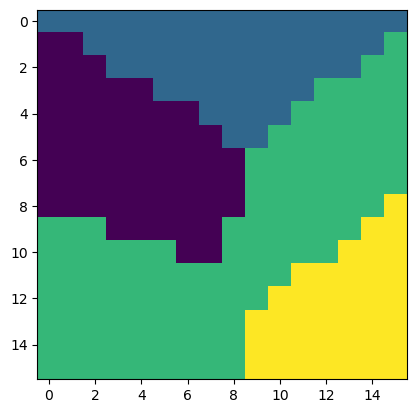

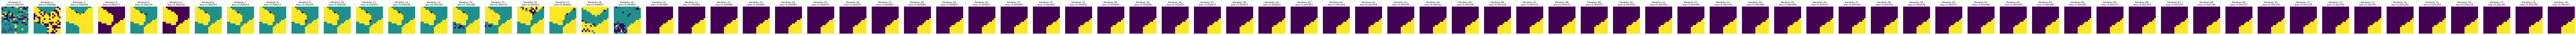

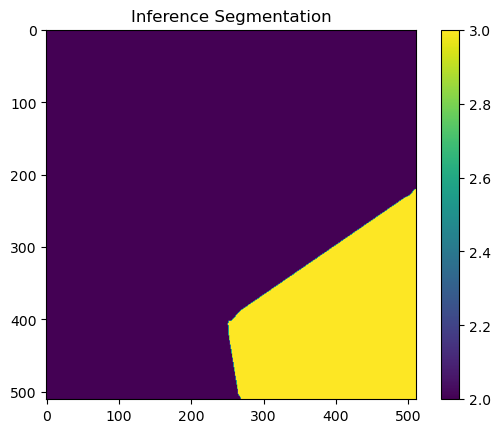

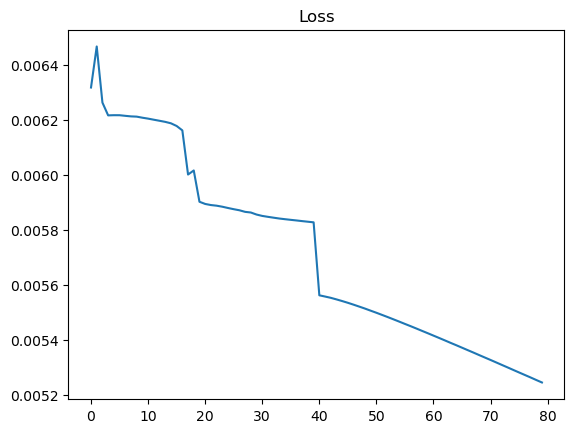

In [146]:
image = plt.imread("synthetic_color_images/0.0/0001.png")[:,:,:3]
segmentor = GNEMS_Segmentor(iterations=2, k=5, d=16, lambda_=0,
                            subset_size=1, lr=0.005, epochs=40, n_filters=32)

%time segmentor.fit(image)
%time seg = segmentor.predict()

plt.imshow(segmentor.initial_labels.argmax(1).detach().cpu().numpy().reshape(16,16))
plt.show()
side_by_side([prob.argmax(1).reshape(16,16) for prob in segmentor.intermediate_probabilities], [f"Iteration {i},\nloss={segmentor.losses[i]:05f}" for i in range(len(segmentor.intermediate_probabilities))])

plt.imshow(seg.argmax(2))
plt.colorbar()
plt.title("Inference Segmentation")
plt.show()

plt.plot(segmentor.losses)
plt.title("Loss")
plt.show()

## Experimenting with supervised learning

### Still with network

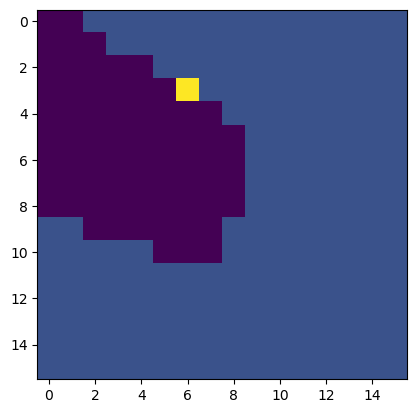

In [147]:
image = plt.imread("synthetic_color_images/0.0/0001.png")[:,:,:3]
segmentor = GNEMS_Segmentor(iterations=2, k=5, d=16, lambda_=0,
                            subset_size=1, lr=0.01, epochs=40, n_filters=32)

gt = plt.imread("synthetic_color_images/0.0/0001.png")[:,:,:3]
seg_colors = np.unique(gt.reshape(-1, gt.shape[2]), axis=0)
labels = np.zeros(gt.shape[:2], dtype=np.int64)
for i, color in enumerate(seg_colors):
    labels[(gt == color).all(axis=2)] = i
labels = labels.reshape(512,512)
labels = torch.from_numpy(labels).type(torch.float32)
labels = torch.nn.functional.interpolate(labels.unsqueeze(0).unsqueeze(0), (16,16), mode="nearest")
labels = labels.squeeze(0).squeeze(0).reshape(256).type(torch.long).numpy()
labels = torch.from_numpy(labels).to(device)
seg = segmentor.fit_supervised(image, labels, method="net")
plt.imshow(seg.reshape(16,16))

### random forest instead of network

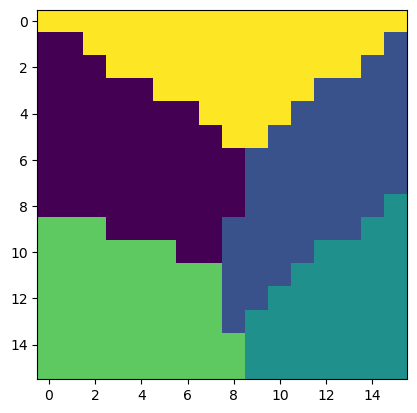

In [148]:
image = plt.imread("synthetic_color_images/0.0/0001.png")[:,:,:3]
segmentor = GNEMS_Segmentor(iterations=2, k=5, d=16, lambda_=0,
                            subset_size=1, lr=0.01, epochs=40, n_filters=32)

gt = plt.imread("synthetic_color_images/0.0/0001.png")[:,:,:3]
seg_colors = np.unique(gt.reshape(-1, gt.shape[2]), axis=0)
labels = np.zeros(gt.shape[:2], dtype=np.int64)
for i, color in enumerate(seg_colors):
    labels[(gt == color).all(axis=2)] = i
labels = labels.reshape(512,512)
labels = torch.from_numpy(labels).type(torch.float32)
labels = torch.nn.functional.interpolate(labels.unsqueeze(0).unsqueeze(0), (16,16), mode="nearest")
labels = labels.squeeze(0).squeeze(0).reshape(256).type(torch.long).numpy()
labels = torch.from_numpy(labels).to(device)
seg = segmentor.fit_supervised(image, labels, method="rf")
plt.imshow(seg.reshape(16,16))